In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


import medmnist

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [38]:
# CARGAMOS EL DATASET BREASTMNIST

#data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

In [39]:
# SACAMOS LA INFO, COLUMNAS Y CLASES Y ASÍ

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
print(info)

print("\n'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}'")

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1', 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364', 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1', 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1', 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1', 'MD5_224': 'b5637

In [8]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*TrainingConfig.BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*TrainingConfig.BATCH_SIZE, shuffle=False)

In [9]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\geo_s\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\geo_s\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    M

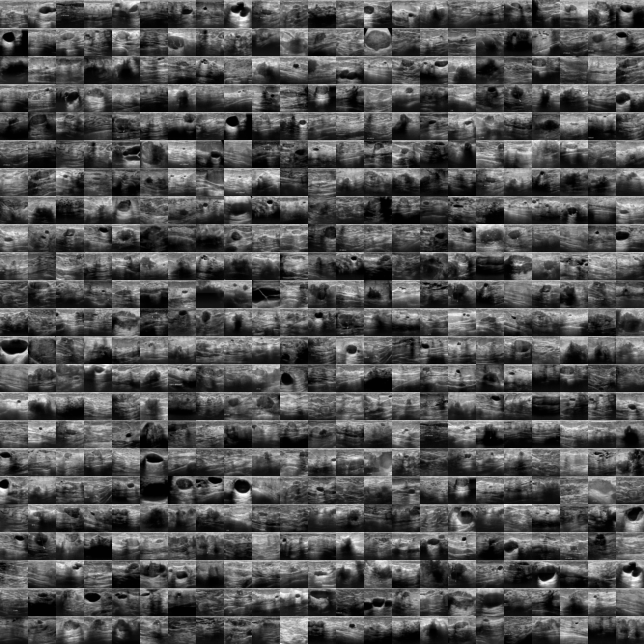

In [10]:
train_dataset.montage(length=23)

In [42]:
# PROTOTIPO DE MODELO HELP 
# AL FINAL ES SIGMOIDE DUH

def cnn_model(input_shape=(28, 28, 3)):
     
    model = Sequential()
     
    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
     
    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
     
    return model

In [41]:
model = cnn_model()
model.summary()

c:\Users\geo_s\Documents\MICAI 2025\MedMNIST\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,361 (1.66 MB)

 Trainable params: 435,361 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# BINARY COSSENTROPY PQ ES BINARIO (NORMAL/BENIGNO O MALIGNO)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'],
             )

In [ ]:
# SEPARAMOS LABELS DE LAS IMAGENES

X_train = train_dataset.imgs
y_train = train_dataset.labels

In [28]:
print(y_train.shape, X_train.shape)

(546, 1) (546, 28, 28)


In [ ]:
# AJUSTAMOS TAMAÑO PARA QUE TENGA LOS REQUISITOS QUE PIDE EL MODELO
# CREO QUE TENGO QUE CAMBIAR PARA QUE SOLO ADMITA EN BLANCO Y NEGRO (28, 28, 1) PARA OPTIMIZARLO 

X_train_expanded = np.expand_dims(X_train, -1)  # (N, 28, 28, 1)
X_train_rgb = np.repeat(X_train_expanded, 3, axis=-1)  # (N, 28, 28, 3)

# X_train_expanded = np.expand_dims(X_train, -1)  # (N, 28, 28, 1)
# X_train_rgb = np.repeat(X_train_expanded, 3, axis=-1)  # (N, 28, 28, 3)
# X_train_resized = tf.image.resize(X_train_rgb, [28, 28]).numpy()  # (N, 32, 32, 3)

# y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [30]:
print(X_train_expanded.shape,
      X_train_rgb.shape)
      #X_train_resized.shape)

(546, 28, 28, 1) (546, 28, 28, 3)


In [ ]:
# ENTRENAMOS

history = model.fit(X_train_rgb,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE, 
                    epochs=TrainingConfig.EPOCHS, 
                    verbose=1, 
                    validation_split=.3,
                   )

Epoch 1/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 0.5812 - loss: 3.4044 - val_accuracy: 0.7622 - val_loss: 1.3144
Epoch 2/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5602 - loss: 2.5364 - val_accuracy: 0.5122 - val_loss: 0.7371
Epoch 3/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5864 - loss: 0.8562 - val_accuracy: 0.7622 - val_loss: 0.7990
Epoch 4/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7173 - loss: 0.8596 - val_accuracy: 0.6402 - val_loss: 0.6342
Epoch 5/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6911 - loss: 0.6081 - val_accuracy: 0.7683 - val_loss: 0.4947
Epoch 6/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7225 - loss: 0.5487 - val_accuracy: 0.7134 - val_loss: 0.5318
Epoch 7/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7723 - loss: 0.5152 - val_accuracy: 0.7805 - val_loss: 0.4719
Epoch 8/31
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7696 - loss: 0.4911 - val_accuracy: 0.7256 - val_loss:

In [35]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

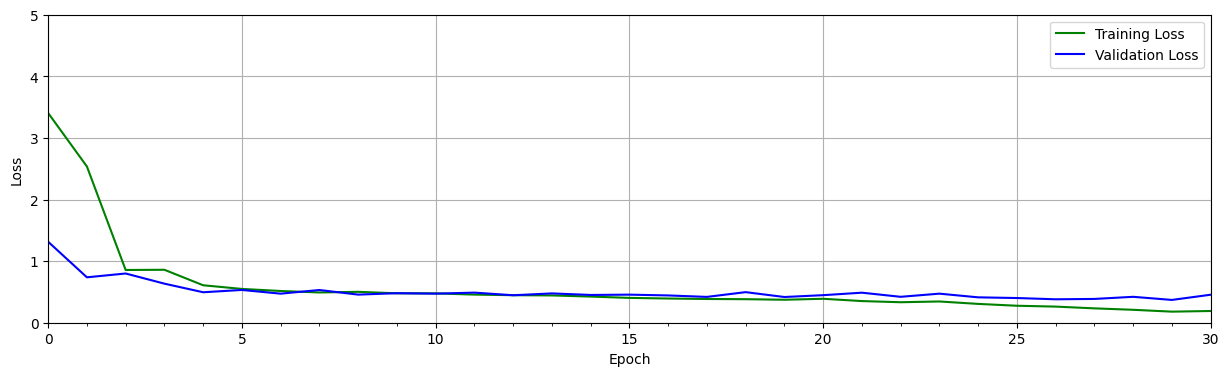

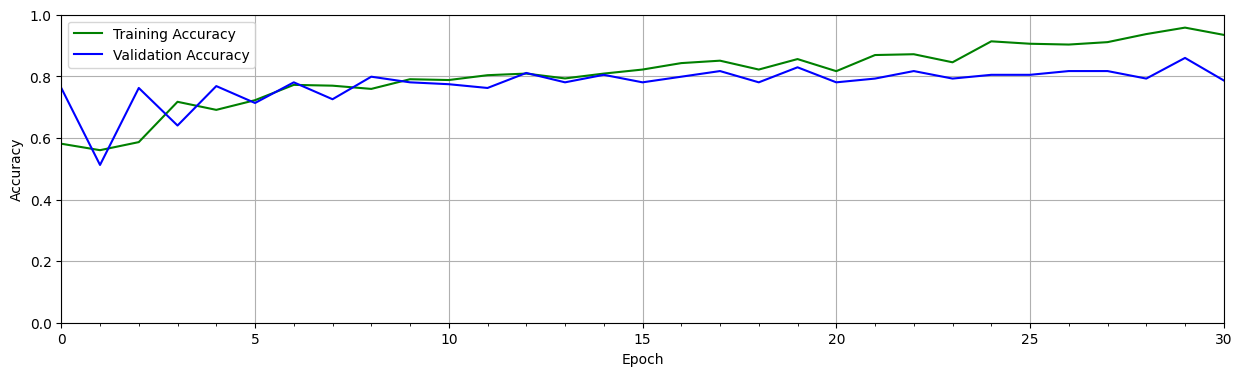

In [36]:
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [37]:
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Resultado Final del Entrenamiento:")
print(f"  - Pérdida de Entrenamiento (Loss): {final_loss:.4f}")
print(f"  - Precisión de Entrenamiento (Accuracy): {final_accuracy:.4f}")
print(f"  - Pérdida de Validación (Validation Loss): {final_val_loss:.4f}")
print(f"  - Precisión de Validación (Validation Accuracy): {final_val_accuracy:.4f}")

Resultado Final del Entrenamiento:
  - Pérdida de Entrenamiento (Loss): 0.1904
  - Precisión de Entrenamiento (Accuracy): 0.9346
  - Pérdida de Validación (Validation Loss): 0.4545
  - Precisión de Validación (Validation Accuracy): 0.7866


## Tiene sobreajuste, puede predecir del entrenamiento hasta un 90% pero del test solo pudo predecir hasta el 78%. Tengo que arreglarlo:(

----
----
----


# ESTO AÚN NO ESTÁ LISTO!!! ↓↓↓

In [66]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [67]:
model = Net(in_channels=n_channels, num_classes=n_classes)

if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [68]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


In [69]:
from medmnist import Evaluator

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics)) 

In [72]:
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.759  acc:0.731
test  auc: 0.729  acc:0.731
